# Import Libraries

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2



# Data Exploaretion

## Load the data

In [15]:
def load_images(folder, image_size=(64, 64)):
    images = []
    for filename in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype(np.float32) / 255.0
            img = (img - 0.5) * 2  # Normalize for tanh activation
            images.append(img)
        else:
            print(f"Warning: Could not load image {img_path}")
    return np.array(images)

real_images = load_images(r'Data\Real Data')

100%|██████████| 1381/1381 [00:26<00:00, 51.42it/s] 


# Data Preprocessing

## Split the data

In [16]:
from sklearn.model_selection import train_test_split
real_images , real_images_test = train_test_split(real_images,test_size=0.2)
print(real_images.shape)
print(real_images_test.shape)

(1104, 64, 64, 3)
(277, 64, 64, 3)


## Data Augmentation

# Data Visualization

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image_histogram(image_folder, color_mode='grayscale', bins=256):
    """
    Plots the histogram of pixel intensities for an image dataset.
    
    Parameters:
    - image_folder: Path to the folder containing the images.
    - color_mode: 'grayscale' for grayscale images, 'rgb' for color images. Default is 'grayscale'.
    - bins: Number of bins for the histogram. Default is 256.
    """
    all_pixels = []

    # Loop through each image in the folder
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        # Read the image in grayscale or color
        if color_mode == 'grayscale':
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        elif color_mode == 'rgb':
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        else:
            raise ValueError("color_mode must be 'grayscale' or 'rgb'")

        if image is not None:
            if color_mode == 'grayscale':
                all_pixels.extend(image.ravel())  # Flatten the grayscale image to 1D array
            elif color_mode == 'rgb':
                # Split the color channels
                channels = cv2.split(image)
                all_pixels.append([channel.ravel() for channel in channels])

    # Plot histogram
    plt.figure(figsize=(10, 5))
    
    if color_mode == 'grayscale':
        plt.hist(all_pixels, bins=bins, color='black', alpha=0.7)
        plt.title("Grayscale Image Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    elif color_mode == 'rgb':
        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            plt.hist(all_pixels[i], bins=bins, color=color, alpha=0.7)
        plt.title("RGB Image Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")

    plt.show()



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image_histogram(image_folder, color_mode='grayscale', bins=256):
    """
    Plots the histogram of pixel intensities for an image dataset.
    
    Parameters:
    - image_folder: Path to the folder containing the images.
    - color_mode: 'grayscale' for grayscale images, 'rgb' for color images. Default is 'grayscale'.
    - bins: Number of bins for the histogram. Default is 256.
    """
    all_pixels = []

    # Loop through each image in the folder
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        # Read the image in grayscale or color
        if color_mode == 'grayscale':
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        elif color_mode == 'rgb':
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        else:
            raise ValueError("color_mode must be 'grayscale' or 'rgb'")

        if image is not None:
            if color_mode == 'grayscale':
                all_pixels.extend(image.ravel())  # Flatten the grayscale image to 1D array
            elif color_mode == 'rgb':
                # Split the color channels
                channels = cv2.split(image)
                all_pixels.append([channel.ravel() for channel in channels])

    # Plot histogram
    plt.figure(figsize=(10, 5))
    
    if color_mode == 'grayscale':
        plt.hist(all_pixels, bins=bins, color='black', alpha=0.7)
        plt.title("Grayscale Image Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    elif color_mode == 'rgb':
        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            plt.hist(all_pixels[i], bins=bins, color=color, alpha=0.7)
        plt.title("RGB Image Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")

    plt.show()




In [ ]:
# Example usage:
image_folder_path = '/path/to/your/images'
plot_image_histogram(image_folder_path, color_mode='grayscale')

# Define the Generator

In [17]:
def residual_block(input_tensor, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the input to the output (skip connection)
    x = layers.Add()([x, input_tensor])
    x = layers.ReLU()(x)
    return x

In [18]:
# 2. Define the Generator
def build_dcgan_generator():
    noise = layers.Input(shape=(100,))
    x = layers.Dense(512 * 4 * 4)(noise)
    x = layers.Reshape((4, 4, 512))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add residual blocks here
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    x = layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # More residual blocks after upsampling
    x = residual_block(x, filters=256)

    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer: ensure output size is 64x64
    output_image = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)

    model = tf.keras.Model(inputs=noise, outputs=output_image)
    return model


# Define the Discriminator

In [19]:
# 3. Define the Discriminator
def build_dcgan_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))  # Dropout for regularization

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


# Build and Compile the GAN

In [20]:
# 4. Build and Compile the GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                          loss='binary_crossentropy', metrics=['accuracy'])
    
    discriminator.trainable = False  # Discriminator is frozen during GAN training
    
    noise = layers.Input(shape=(100,))
    generated_image = generator(noise)
    
    # Pass the generated image through the discriminator
    validity = discriminator(generated_image)
    
    gan = tf.keras.Model(noise, validity)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                loss='binary_crossentropy')
    
    return gan


# Training Process

In [21]:
# 6. Plot Generated Images
def plot_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [22]:
# 7. Save Generated Images
def save_generated_image(epoch, generator):
    noise = np.random.normal(0, 1, (1, 100))
    generated_image = generator.predict(noise)[0]
    generated_image = 0.5 * generated_image + 0.5
    
    if not os.path.exists('generated_images'):
        os.makedirs('generated_images')
    
    plt.imshow(generated_image)
    plt.axis('off')
    plt.savefig(f"generated_images/epoch_{epoch}.png")
    plt.close()


In [23]:
def load_latest_checkpoint(generator_builder, discriminator_builder, gan_builder, checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        return None, None, None, 0  # No checkpoints, start from epoch 0

    checkpoint_files = os.listdir(checkpoint_dir)
    if not checkpoint_files:
        return None, None, None, 0

    generator_files = [f for f in checkpoint_files if f.startswith('generator_epoch_') and f.endswith('.h5')]
    discriminator_files = [f for f in checkpoint_files if f.startswith('discriminator_epoch_') and f.endswith('.h5')]
    gan_files = [f for f in checkpoint_files if f.startswith('gan_epoch_') and f.endswith('.h5')]

    if not generator_files or not discriminator_files or not gan_files:
        return None, None, None, 0

    epochs = [int(f.split('_epoch_')[1].split('.h5')[0]) for f in generator_files]
    latest_epoch = max(epochs)

    generator = generator_builder()
    discriminator = discriminator_builder()
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                          loss='binary_crossentropy', metrics=['accuracy'])
    gan = gan_builder(generator, discriminator)

    generator.load_weights(os.path.join(checkpoint_dir, f'generator_epoch_{latest_epoch}.h5'))
    discriminator.load_weights(os.path.join(checkpoint_dir, f'discriminator_epoch_{latest_epoch}.h5'))
    gan.load_weights(os.path.join(checkpoint_dir, f'gan_epoch_{latest_epoch}.h5'))

    print(f"Loaded models from epoch {latest_epoch}")

    return generator, discriminator, gan, latest_epoch

In [24]:
def train_gan(generator, discriminator, gan, real_images, epochs=10000, batch_size=64, discriminator_steps=2, start_epoch=0):
    half_batch = int(batch_size / 2)

    for epoch in range(start_epoch, epochs):
        for _ in range(discriminator_steps):
            # Train the discriminator on real images
            idx_real = np.random.randint(0, real_images.shape[0], half_batch)
            real_batch = real_images[idx_real]

            # Generate new fake images
            noise = np.random.normal(0, 1, (half_batch, 100))
            generated_images = generator.predict(noise)

            # Train discriminator on real images (label smoothing applied)
            real_labels = np.ones((half_batch, 1)) * 0.9  # Smoothing real labels to 0.9
            d_loss_real = discriminator.train_on_batch(real_batch, real_labels)

            # Train discriminator on generated images
            fake_labels = np.zeros((half_batch, 1))  # Label for fake data is 0
            d_loss_generated = discriminator.train_on_batch(generated_images, fake_labels)

            # Calculate the average loss for the discriminator
            d_loss = (d_loss_real[0] + d_loss_generated[0]) / 2

        # Train the generator: generate noise and try to fool the discriminator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))  # Generator tries to make discriminator classify generated images as real
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress and save checkpoints
        if epoch % 100 == 0:
            print(f"{epoch}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}")
            save_generated_image(epoch, generator)
            plot_generated_images(generator, epoch)

        # Save model checkpoints every 5000 epochs
        if epoch % 5000 == 0 and epoch != 0:
            if not os.path.exists('checkpoints'):
                os.makedirs('checkpoints')
            generator.save_weights(f"checkpoints/generator_epoch_{epoch}.h5")
            discriminator.save_weights(f"checkpoints/discriminator_epoch_{epoch}.h5")
            gan.save_weights(f"checkpoints/gan_epoch_{epoch}.h5")
            print(f"Saved checkpoints at epoch {epoch}")


# Run the Training

1/1 [==============================] - 0s 35ms/step
0/5100, D Loss: 0.6538679599761963, G Loss: 0.5929170846939087
1/1 [==============================] - 0s 40ms/step


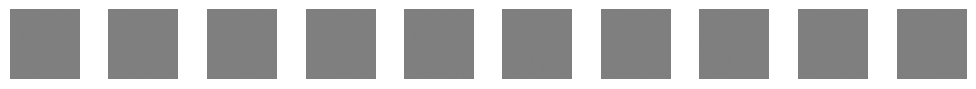

1/1 [==============================] - 0s 47ms/step
100/5100, D Loss: 0.21262994804419577, G Loss: 4.957764148712158
1/1 [==============================] - 0s 105ms/step


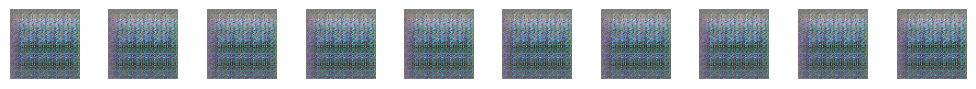

1/1 [==============================] - 0s 67ms/step
200/5100, D Loss: 0.1788612303789705, G Loss: 0.047105319797992706
1/1 [==============================] - 0s 74ms/step


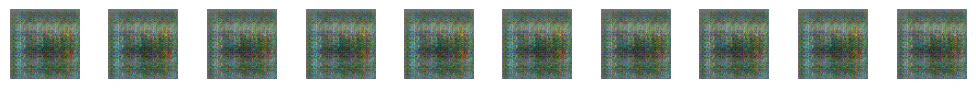

1/1 [==============================] - 0s 48ms/step
300/5100, D Loss: 0.18783216923475266, G Loss: 0.03234086558222771
1/1 [==============================] - 0s 75ms/step


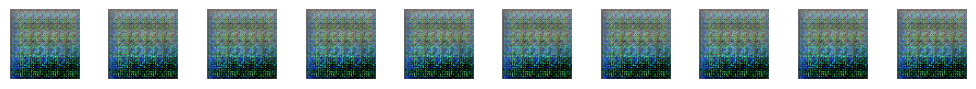

1/1 [==============================] - 0s 61ms/step
400/5100, D Loss: 0.20266179367899895, G Loss: 0.08559367805719376
1/1 [==============================] - 0s 25ms/step


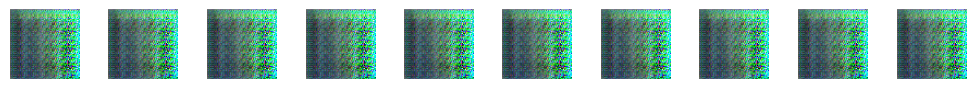

1/1 [==============================] - 0s 28ms/step
500/5100, D Loss: 0.19919112650677562, G Loss: 0.12671786546707153
1/1 [==============================] - 0s 37ms/step


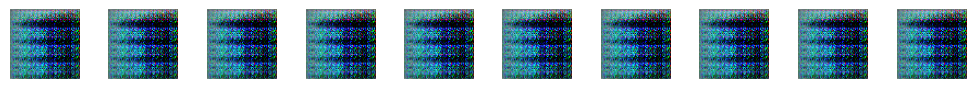

1/1 [==============================] - 0s 43ms/step
600/5100, D Loss: 0.1777392562944442, G Loss: 0.0641365498304367
1/1 [==============================] - 0s 30ms/step


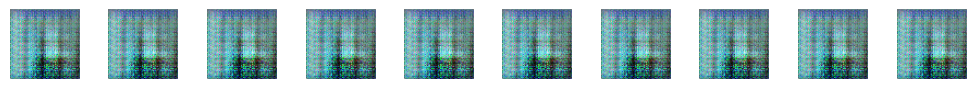

1/1 [==============================] - 0s 371ms/step
700/5100, D Loss: 0.17673706903588027, G Loss: 0.03731338679790497
1/1 [==============================] - 0s 126ms/step


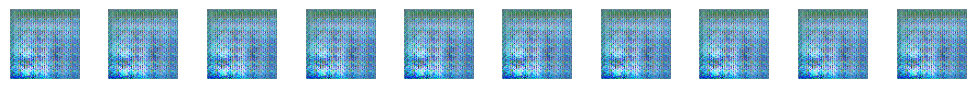

1/1 [==============================] - 0s 67ms/step
800/5100, D Loss: 0.18049459136091173, G Loss: 0.0492309108376503
1/1 [==============================] - 0s 47ms/step


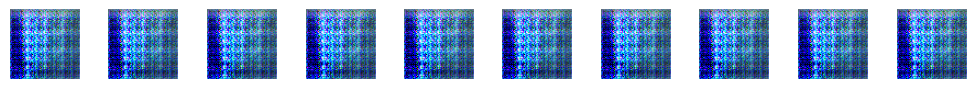

1/1 [==============================] - 0s 79ms/step
900/5100, D Loss: 0.1722417138516903, G Loss: 0.017487507313489914
1/1 [==============================] - 0s 79ms/step


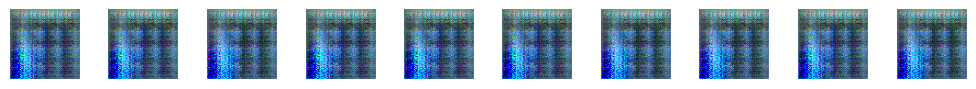

1/1 [==============================] - 0s 26ms/step
1000/5100, D Loss: 0.1707166894339025, G Loss: 0.013264700770378113
1/1 [==============================] - 0s 30ms/step


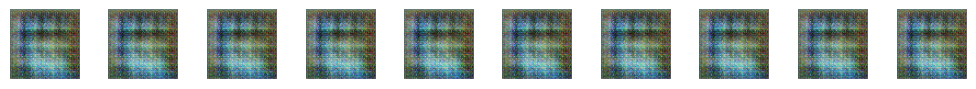

1/1 [==============================] - 0s 31ms/step
1100/5100, D Loss: 0.16580264532240108, G Loss: 0.01456812396645546
1/1 [==============================] - 0s 70ms/step


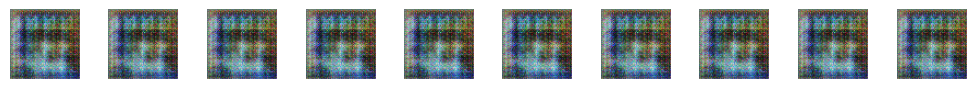

1/1 [==============================] - 0s 62ms/step
1200/5100, D Loss: 0.16498209309065714, G Loss: 0.2079392522573471
1/1 [==============================] - 0s 73ms/step


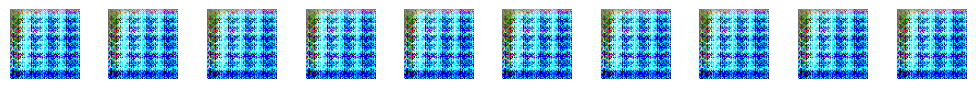

1/1 [==============================] - 0s 64ms/step
1300/5100, D Loss: 0.17730464413762093, G Loss: 5.674434185028076
1/1 [==============================] - 0s 73ms/step


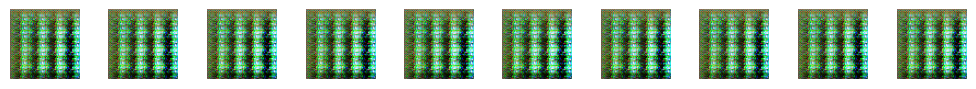

1/1 [==============================] - 0s 67ms/step
1400/5100, D Loss: 0.17043370427563787, G Loss: 0.04232419654726982
1/1 [==============================] - 0s 79ms/step


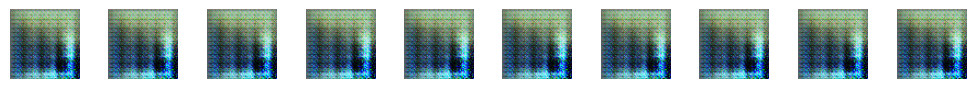

1/1 [==============================] - 0s 40ms/step
1500/5100, D Loss: 0.438409898430109, G Loss: 0.026018841192126274
1/1 [==============================] - 0s 56ms/step


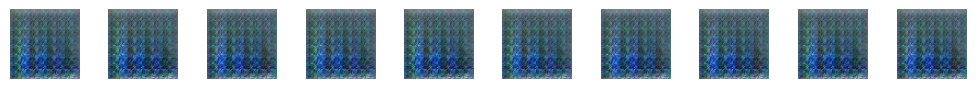

1/1 [==============================] - 0s 64ms/step
1600/5100, D Loss: 0.16874436265788972, G Loss: 0.025780469179153442
1/1 [==============================] - 0s 58ms/step


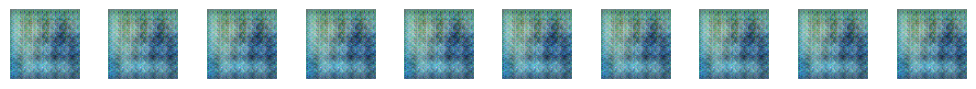

1/1 [==============================] - 0s 66ms/step
1700/5100, D Loss: 0.16764452797360718, G Loss: 0.04909922182559967
1/1 [==============================] - 0s 83ms/step


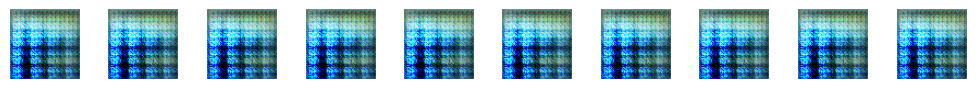

1/1 [==============================] - 0s 25ms/step
1800/5100, D Loss: 0.1746948156505823, G Loss: 0.1676810085773468
1/1 [==============================] - 0s 28ms/step


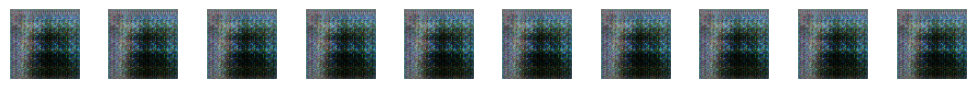

1/1 [==============================] - 0s 25ms/step
1900/5100, D Loss: 0.17367812292650342, G Loss: 0.07356773316860199
1/1 [==============================] - 0s 26ms/step


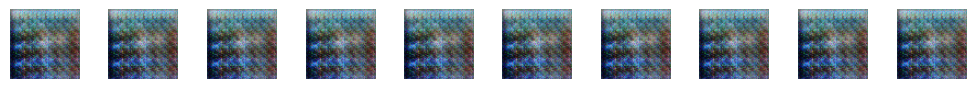

1/1 [==============================] - 0s 53ms/step
2000/5100, D Loss: 2.4349334836006165, G Loss: 2.692958354949951
1/1 [==============================] - 0s 54ms/step


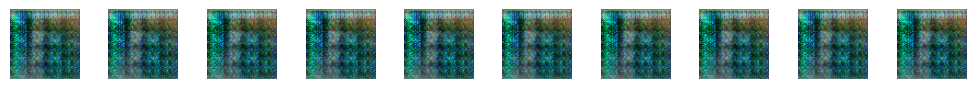

1/1 [==============================] - 1s 605ms/step


In [ ]:
generator, discriminator, gan, start_epoch = load_latest_checkpoint(build_dcgan_generator, build_dcgan_discriminator, build_gan)
if generator is None:
    generator = build_dcgan_generator()
    discriminator = build_dcgan_discriminator()
    gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, real_images, epochs=5100, batch_size=64, start_epoch=start_epoch)

# Evalualte the models

In [61]:
# 8. Evaluation Function
def evaluate_models(generator, discriminator, real_images, batch_size=64, examples=10):
    # Select a batch of real images
    idx_real = np.random.randint(0, real_images.shape[0], batch_size)
    real_batch = real_images[idx_real]
    real_labels = np.ones((batch_size, 1))
    
    # Evaluate discriminator on real images
    d_loss_real = discriminator.evaluate(real_batch, real_labels, verbose=0)
    
    # Generate a batch of new fake images using the generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator.predict(noise)
    fake_labels = np.zeros((batch_size, 1))
    
    # Evaluate discriminator on generated images
    d_loss_generated = discriminator.evaluate(generated_images, fake_labels, verbose=0)
    
    # Calculate the overall discriminator loss
    d_loss = (d_loss_real[0] + d_loss_generated[0]) / 2
    d_accuracy = (d_loss_real[1] + d_loss_generated[1]) / 2
    
    # Evaluate generator performance (generator's loss is based on fooling the discriminator)
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.evaluate(noise, valid_labels, verbose=0)
    
    print(f"Discriminator Loss on Real: {d_loss_real[0]}, Generated: {d_loss_generated[0]}")
    print(f"Discriminator Accuracy: {d_accuracy * 100:.2f}%")
    print(f"Generator Loss: {g_loss}")
    
    # Visualize a few generated images
    print("Generated Images:")
    plot_generated_images(generator, epoch='Evaluation', examples=examples, dim=(1, examples), figsize=(10, 1))


2/2 [==============================] - 0s 25ms/step
Discriminator Loss on Real: 0.31281065940856934, Fake: 0.20278942584991455, Generated: 0.807188868522644
Discriminator Accuracy: 59.90%
Generator Loss: 0.5911768674850464
Generated Images:
1/1 [==============================] - 0s 19ms/step


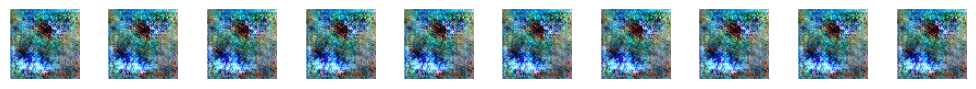

In [62]:
# 9. Run the Evaluation
evaluate_models(generator, discriminator, real_images_test)

# 